## Importações

In [135]:
import torch
import torch.nn as nn
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from sklearn.manifold import TSNE

## Funções e classes auxiliares

In [136]:
class EmbeddingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=128):
        super(EmbeddingAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, encoding_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

def remover_tags_html(texto):
    """Remove tags HTML do texto."""
    return re.sub(r'<[^>]*>', '', texto)

def normalizar_espacos(texto):
    """Substitui múltiplos espaços por um único e remove espaços extras nas bordas."""
    return re.sub(r'\s+', ' ', texto).strip()

def remover_caracteres_especiais(texto):
    """Remove caracteres especiais indesejados, exceto letras, números, espaços e pontuação comum."""
    return re.sub(r'[^\w\s.,!?\'\"-]', '', texto)

def limpar_texto(texto):
    """Aplica todas as etapas de limpeza ao texto."""
    texto = remover_tags_html(texto)
    texto = normalizar_espacos(texto)
    texto = remover_caracteres_especiais(texto)
    return texto

## Coletando dado

In [137]:
df = pd.read_csv("Movies_Reviews_modified_version2.csv")
df['Description'] = df['Description'].apply(limpar_texto)

## Treinando o modelo

In [168]:
# Carregar o modelo de embeddings pré-treinado
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Carregar os dados (supondo que seja um arquivo CSV com uma coluna 'text')
data = pd.read_csv('Movies_Reviews_modified_version2.csv')
texts = data['Description'].apply(limpar_texto).tolist()

# Obter embeddings pré-treinados
embeddings = model.encode(texts, convert_to_tensor=True)

# Dividir em treino e teste
train_embeddings, test_embeddings = train_test_split(embeddings, test_size=0.2, random_state=42)

# Converter para tensores PyTorch
train_embeddings = torch.stack([torch.tensor(emb) for emb in train_embeddings]).to('cuda')
test_embeddings = torch.stack([torch.tensor(emb) for emb in test_embeddings]).to('cuda')

# Definir o autoencoder
input_dim = train_embeddings.shape[1]
encoding_dim = 128
autoencoder = EmbeddingAutoencoder(input_dim, encoding_dim).to('cuda')

# Definir o otimizador e a função de perda
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Treinar o autoencoder
epochs = 80
for epoch in tqdm(range(epochs)):
    autoencoder.train()
    optimizer.zero_grad()
    decoded, encoded = autoencoder(train_embeddings)
    loss = criterion(decoded, train_embeddings)
    loss.backward()
    optimizer.step()

# Salvar o modelo ajustado e embeddings otimizados
torch.save(autoencoder.state_dict(), 'embedding_autoencoder.pth')
optimized_embeddings = autoencoder.encoder(embeddings).detach().cpu().numpy()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-168-361c154da6f4>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_embeddings = torch.stack([torch.tensor(emb) for emb in train_embeddings]).to('cuda')
<ipython-input-168-361c154da6f4>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_embeddings = torch.stack([torch.tensor(emb) 

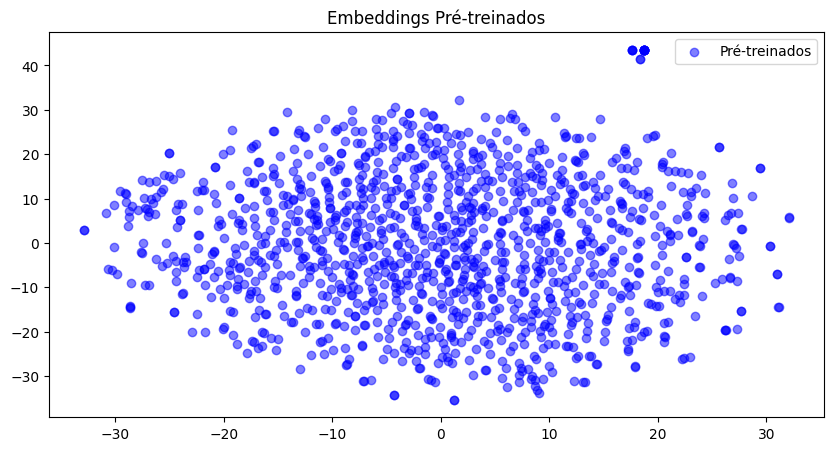

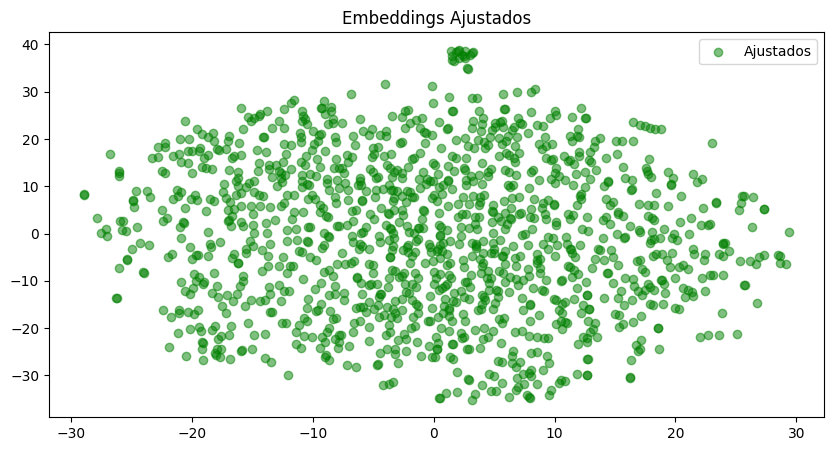

In [169]:
# Obter os embeddings ajustados
with torch.no_grad():
    _, tuned_embeddings = autoencoder(train_embeddings)

# Reduzir dimensionalidade com TSNE para os embeddings pré-treinados
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(train_embeddings.cpu())

# Reduzir dimensionalidade com TSNE para os embeddings ajustados
tuned_embeddings_2d = tsne.fit_transform(tuned_embeddings.cpu())

# Plotar os embeddings pré-treinados
plt.figure(figsize=(10, 5))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.5, label='Pré-treinados')
plt.title('Embeddings Pré-treinados')
plt.legend()
plt.show()

# Plotar os embeddings ajustados
plt.figure(figsize=(10, 5))
plt.scatter(tuned_embeddings_2d[:, 0], tuned_embeddings_2d[:, 1], c='green', alpha=0.5, label='Ajustados')
plt.title('Embeddings Ajustados')
plt.legend()
plt.show()

In [172]:
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Função para obter o embedding reduzido de uma consulta
def get_reduced_embedding(query, model, autoencoder):
    # Gera o embedding da consulta e ajusta pelo autoencoder
    query_embedding = model.encode([query], convert_to_tensor=True).detach()
    query_embedding_reduced = autoencoder.encoder(query_embedding).detach().cpu().numpy()
    return query_embedding_reduced

# Função para calcular as similaridades entre a consulta e os embeddings do conjunto
def calculate_similarities(query_embedding, embeddings, min_similarity):
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    relevant_indices = [(i, sim) for i, sim in enumerate(similarities) if sim >= min_similarity]
    return sorted(relevant_indices, key=lambda x: x[1], reverse=True)

# Função principal de busca
def perform_search(query, model, autoencoder, embeddings, df, top_k=10, min_similarity=0.6):
    query_embedding = get_reduced_embedding(query, model, autoencoder)
    ranked_indices = calculate_similarities(query_embedding, embeddings, min_similarity)

    # Obter resultados únicos e limitados por top_k
    seen_texts, final_results = set(), []
    for idx, sim in ranked_indices:
        text = df.iloc[idx]['Description']
        if text not in seen_texts:
            seen_texts.add(text)
            final_results.append((text, sim))
            if len(final_results) >= top_k:
                break

    # Separar os textos e similaridades para retorno
    unique_texts, unique_similarities = zip(*final_results) if final_results else ([], [])
    return list(unique_texts), list(unique_similarities)


In [ ]:
search_terms = ["action adventure", "romantic musical set in the 1980s", "cyberpunk detective noir"]

def batch_search(search_terms, model, autoencoder, embeddings, df, top_k=10, min_similarity=0.6):
    results = {}
    for search_term in search_terms:
        unique_texts, unique_similarities = perform_search(search_term, model, autoencoder, embeddings, df, top_k, min_similarity)
        results[search_term] = {
            "texts": unique_texts,
            "similarities": unique_similarities
        }
    return results

search_results = batch_search(search_terms, model, autoencoder, optimized_embeddings, df)

for search_phrase, result in search_results.items():
    print(f"Entrada: {search_phrase}")
    for text, similarity in zip(result["texts"], result["similarities"]):
        print(f"- Text: {text} (Similarity: {similarity:.2f})")
    print("\n" + "="*40 + "\n")


Query: action adventure
- Text: A time traveling city under attack by cyborg robots in 4039 travels back in time sending two troopers in advance to the Australian desert year 1988 to prepare for its arrival. The enemy tracks them. (Similarity: 0.68)
- Text: During the Nazi occupation of Poland, an acting troupe becomes embroiled in a Polish soldier's efforts to track down a German spy. (Similarity: 0.65)
- Text: An American cowboy living in Mexico discovers his cattle are being eaten by a giant prehistoric dinosaur. (Similarity: 0.62)


Query: romantic musical set in the 1980s
- Text: High-octane romance set in the recognizable - and sometimes gritty - world of Brighton's homegrown youth, as Boy Racer gangs uneasily coexist with the Indie scene. (Similarity: 0.66)
- Text: A Playful Sex Comedy About a Couple Looking to Spice Up Their Sex Life. Written and Directed by Thomas G. Waites From Movie Classics Including "The Thing." (Similarity: 0.65)
- Text: Shakespeare's famous play is updat